In [ ]:
#Clean up code
#add iterative testing
#create test result charts
#output results and charts to folders
#add diagonal to MAE
#create MFE
#find perfect trades to determine optimal moving average

In [1]:
%matplotlib qt
#%matplotlib inline

#import statements 
import xlsxwriter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import matplotlib.dates as dates
import datetime
import time
import csv

In [26]:
#Test Class

#from decimal import getcontext, Decimal

#getcontext().prec=3

#find a way to append the array

np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

class Test:
    def __init__(self, acct_bal, equity):
        self.init_bal = acct_bal #initial balance
        self.acct_bal = acct_bal #ongoing account balance
        self.equity = equity #unrealized p/L
        self.buy_status = 1 #these aren't really doing anything
        self.sell_status = 0
        self.trades = 1
        self.profit = 0
        self.units = 0
        self.trade_profit = 0
        self.activity = np.zeros((1,), dtype=[('Trade', 'int32'), ('Ask', 'float64'), ('Ask_TID', 'int32'), 
                                              ('Units','int32'), ('Bid', 'float64'), ('Bid_TID','int32'), 
                                              ('Profit', 'float64'), ('Max_DD', 'float64'), ('Max_DD_Bid', 'float64'), 
                                              ('Max_DD_TID','int32')])
        self.new_activity = np.empty_like(self.activity)
        self.buy_start = 0
        self.buy_end = 0
    
    def buy(self, amt, i):
        #you buy at the ask and sell at the bid (quoted from perspective of market maker)
        
        #pull arr_analysis tuple to assign variable values
        ask = arr_analysis[i]['Ask']
        TID = arr_analysis[i]['TID']
        self.buy_start = i
        
        
        #calculate the buy
        self.units = int((amt)/ask) #calcluate units per trade at amount
        self.equity += (self.units * ask) #set equity to unrealized p/l (this is more accurately "position")
        self.acct_bal -= self.equity #subtract equity from ongoing account balance
        
        #update activity
        self.new_activity[0]['Trade']= self.trades
        self.new_activity[0]['Ask']= ask
        self.new_activity[0]['Ask_TID']= TID
        self.new_activity[0]['Units']= self.units
                
        #set flags
        self.buy_status = 0
        self.sell_status = 1
        
        #test area
        #print("Currently buying at TID:", TID, ",", unit,"Units for", amt, "at", bid)
        #print("Units are", amt, bid, int((amt/bid)))
        
    def sell(self, i, stop_loss = None):
        
        #pull arr_analysis tuple to assign variable values
        bid = arr_analysis[i]['Bid']
        TID = arr_analysis[i]['TID']
        self.buy_end = i + 1
        
        #determine the maximum drawdown
        ask = self.new_activity['Ask'] #the price you bought at
        ask_tid = int(self.new_activity['Ask_TID']) #the ID of the tick for the price you bought at
        min_bid = np.amin(arr_analysis[self.buy_start:self.buy_end]['Bid']) #the lowest purchase price in the range of your purchase to sale
        min_bid_tuple = arr_analysis[np.argmin(arr_analysis[self.buy_start:self.buy_end]['Bid'])] #the row of the lowest purchase price in the range of your purchase to sale
        min_bid_tid = min_bid_tuple['TID'] #the ID of the lowest purchase price
        
        self.new_activity[0]['Max_DD'] = (min_bid * self.units) - self.equity 
        self.new_activity[0]['Max_DD_TID'] = min_bid_tid
        self.new_activity[0]['Max_DD_Bid'] = min_bid
        
        if stop_loss == None or stop_loss > abs(self.new_activity[0]['Max_DD']):
                    
            #calculate the sale
            self.acct_bal = self.acct_bal + (self.units * bid) #add realized p/l to account balance        
            self.trade_amt = self.units * bid #calculate trade value
            self.trade_profit = (self.units * bid) - self.equity #calculate the trade profit
            self.profit += self.trade_profit #update running profit
            self.equity = 0 #need to change this so it takes bid into accountif stop_loss == None or stop_loss < abs(self.new_activity[0]['Max_DD']):  
                    
                    
        else:
            
            print("The current trade is:", self.trades)
            print("The current ask is:", self.new_activity[0]['Ask'])
            print("The current equity is:", self.equity)
            print("The current units are:", self.units)
            
            max_dd_criteria = (self.equity-stop_loss)/self.units #calculate the Bid value of your loss stop
            
            print("The current min bid is:", min_bid)
            print("The min bid criteria is:", max_dd_criteria)
            print("Array analysis starts at:", self.buy_start, "and ends at:", self.buy_end)
            
            max_dd_min_bid = np.empty_like(arr_analysis) #create the empty array for your analysis
            
            max_dd_min_bid = arr_analysis[self.buy_start:self.buy_end] #fill the array with your start and stop
            
            ##DATA EXPORT
            df_export = pd.DataFrame(data=max_dd_min_bid,    # values
            columns=max_dd_min_bid.dtype.names)
        
            #Export sample data
            #Create a Pandas Excel writer using XlsxWriter as the engine.
            writer = pd.ExcelWriter('C:\\Users\\pebaqu\\Desktop\\Personal\\Python\\JupyterExports\\max_dd_min_bid' + str(self.trades) + '.xlsx', engine='xlsxwriter')

            #Convert the dataframe to an XlsxWriter Excel object.
            df_export.to_excel(writer, sheet_name='Sheet1')
            #Close the Pandas Excel writer and output the Excel file.
            writer.save()
            ##END DATA EXPORT
            
            #np.squeeze(np.take(max_dd_min_bid, 
            
            arr_max_dd_min_bid = np.squeeze(np.take(max_dd_min_bid, np.where(max_dd_min_bid['Bid']>= max_dd_criteria)))
            
            ##DATA EXPORT
            df_export = pd.DataFrame.from_records(data=arr_max_dd_min_bid)#,    # values
            #columns=arr_max_dd_min_bid.dtype.names)
        
            #Export sample data
            #Create a Pandas Excel writer using XlsxWriter as the engine.
            writer = pd.ExcelWriter('C:\\Users\\pebaqu\\Desktop\\Personal\\Python\\JupyterExports\\arr_max_dd_min_bid' + str(self.trades) + '.xlsx', engine='xlsxwriter')

            #Convert the dataframe to an XlsxWriter Excel object.
            df_export.to_excel(writer, sheet_name='Sheet1')
            #Close the Pandas Excel writer and output the Excel file.
            writer.save()
            ##END DATA EXPORT
            
            min_bid = np.amin(arr_max_dd_min_bid['Bid']) #the lowest purchase price in the range of your purchase to sale
            
            print("The actual minimum bid is:", min_bid)
            
            min_bid_tuple = arr_analysis[np.argmin(arr_max_dd_min_bid['Bid'])] #the row of the lowest purchase price in the range of your purchase to sale
            min_bid_tid = min_bid_tuple['TID'] #the ID of the lowest purchase price

            self.new_activity[0]['Max_DD'] = (min_bid * self.units) - self.equity 
            self.new_activity[0]['Max_DD_TID'] = min_bid_tid
            self.new_activity[0]['Max_DD_Bid'] = min_bid
            
            #calculate the sale
            self.acct_bal = self.acct_bal + (self.units * min_bid) #add realized p/l to account balance        
            self.trade_amt = self.units * min_bid #calculate trade value
            self.trade_profit = (self.units * min_bid) - self.equity #calculate the trade profit
            self.profit += self.trade_profit #update running profit
            self.equity = 0 #need to change this so it takes bid into accountif stop_loss == None or stop_loss < abs(self.new_activity[0]['Max_DD']):  
            
        #update activity
        self.new_activity[0]['Bid'] = bid
        self.new_activity[0]['Bid_TID'] = TID
        self.new_activity[0]['Profit']=self.trade_profit
        self.activity = np.append(self.activity, self.new_activity)
         
        #set flags
        self.buy_status = 1
        self.sell_status = 0
        self.trades += 1
        
        
    
    def acct_status(self):
        print("The current account balance is:{0:.3f}".format(self.acct_bal), 
              "The current equity is:{0:.3f}".format(self.equity),
              "The profit for this trade was:{0:.3f}".format(self.trade_profit),
              "The current profit is:{0:.3f}".format(self.profit), 
              #"The drawdown for this trade is:{0:.3f}".format(self.activity[0]['Max_DD']),
              self.activity,
              sep='\n')

'''        
test1 = Test(10000, 0)
test1.acct_status()
test1.buy(1000,137.345,1)
test1.acct_status()
test1.sell(140.567,2)
test1.acct_status()
test1.buy(1000,125.987,3)
test1.acct_status()
test1.sell(130.652,4)
test1.acct_status()
#print(test1.name())
'''

'''
                
        df_test = pd.DataFrame(data=arr_analysis[self.buy_start:self.buy_end],    # values
            columns=arr_analysis.dtype.names)
        
        #Export sample data
        #Create a Pandas Excel writer using XlsxWriter as the engine.
        writer = pd.ExcelWriter('C:\\Users\\pebaqu\\Desktop\\Personal\\Python\\JupyterExports\\Max_DD_' + str(self.trades) + '.xlsx', engine='xlsxwriter')
        
        #Convert the dataframe to an XlsxWriter Excel object.
        df_test.to_excel(writer, sheet_name='Sheet1')
        #Close the Pandas Excel writer and output the Excel file.
        writer.save()        
        
        
        
        print("The current beginning index is:", self.buy_start)
        print("the current ending index is:", self.buy_end)
        print("The current subarray is:", arr_analysis[self.buy_start:self.buy_end])
        print("The max drawdown tuple is:", arr_analysis[np.argmin(arr_analysis[self.buy_start:self.buy_end]['Bid'])] )
'''
#test area
        #print("Currently selling at TID:", TID, "for", ask)
        #print("The current ask is:", ask)
        #print("Array slice:", arr_analysis[1:2])
        #print("The current ask_tid is:", ask_tid)
        #print("The current TID is:", TID)
        #print("The current min bid is:", min_bid)
        #print("The current units are:", self.units)
        #print("The current equity is:", self.equity)

'\n                \n        df_test = pd.DataFrame(data=arr_analysis[self.buy_start:self.buy_end],    # values\n            columns=arr_analysis.dtype.names)\n        \n        #Export sample data\n        #Create a Pandas Excel writer using XlsxWriter as the engine.\n        writer = pd.ExcelWriter(\'C:\\Users\\pebaqu\\Desktop\\Personal\\Python\\JupyterExports\\Max_DD_\' + str(self.trades) + \'.xlsx\', engine=\'xlsxwriter\')\n        \n        #Convert the dataframe to an XlsxWriter Excel object.\n        df_test.to_excel(writer, sheet_name=\'Sheet1\')\n        #Close the Pandas Excel writer and output the Excel file.\n        writer.save()        \n        \n        \n        \n        print("The current beginning index is:", self.buy_start)\n        print("the current ending index is:", self.buy_end)\n        print("The current subarray is:", arr_analysis[self.buy_start:self.buy_end])\n        print("The max drawdown tuple is:", arr_analysis[np.argmin(arr_analysis[self.buy_start:se

In [3]:
%%time

#Data wrangling

#Data import
df_tick_data = pd.read_csv('C:\\Users\\pebaqu\\Downloads\\USDJPY-2018-01.csv', parse_dates=True )
df_tick_data['TTime']=df_tick_data['TTime'].apply(
    lambda x: np.datetime64(datetime.datetime.strptime(x, '%Y%m%d %H:%M:%S.%f'),unit = 'ms'))

#Data sorting and base column creation
df_tick_data_sorted=df_tick_data.sort_values(by=['TTime'])
df_tick_data_sorted.set_index('TTime')
df_tick_data_sorted['TID'] = range(0, len(df_tick_data_sorted))
df_tick_data_sorted['Bid_Ask_Spread']=df_tick_data_sorted['Bid'] - df_tick_data_sorted['Ask']
df_tick_data_sorted.index = df_tick_data_sorted['TTime']

#Base dataset creation
df_analysis=pd.DataFrame(df_tick_data_sorted)

#Stat column creation
df_analysis['Bid_Fast_Avg']=df_analysis.Bid.rolling(200).mean()
df_analysis['Prev_Bid_Fast_Avg']=df_analysis['Bid_Fast_Avg'].shift()
df_analysis['Bid_Slow_Avg']=df_analysis.Bid.rolling(20).mean()
df_analysis['Prev_Bid_Slow_Avg']=df_analysis['Bid_Slow_Avg'].shift()
df_analysis['Ask_Fast_Avg']=df_analysis.Ask.rolling(200).mean()
df_analysis['Prev_Ask_Fast_Avg']=df_analysis['Ask_Fast_Avg'].shift()
df_analysis['Ask_Slow_Avg']=df_analysis.Ask.rolling(20).mean()
df_analysis['Prev_Ask_Slow_Avg']=df_analysis['Ask_Slow_Avg'].shift()
df_analysis['Spread_Fast_Avg']=df_analysis.Bid_Ask_Spread.rolling(200).mean()
df_analysis['Prev_Spread_Fast_Avg']=df_analysis['Spread_Fast_Avg'].shift()
df_analysis['Spread_Slow_Avg']=df_analysis.Bid_Ask_Spread.rolling(20).mean()
df_analysis['Prev_Spread_Slow_Avg']=df_analysis['Spread_Slow_Avg'].shift()

#Final analysis dataset creation
df_analysis_final=df_analysis.dropna()#.head(100000)
#display(df_analysis_final)

#analysis array creation

arr_ip = [tuple(i) for i in df_analysis_final.as_matrix()]

dtyp = np.dtype(list(zip(df_analysis_final.dtypes.index, df_analysis_final.dtypes)))
#print(dtyp)

arr_analysis = np.array(arr_ip, dtype=dtyp)


C:\Users\pebaqu\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Wall time: 2min 54s


In [37]:
%%time

#Test on actual data using array. Much faster, 12.1 seconds
#TTime isn't unique! 2018-01-01 22:13:03.523000 USDJPY

test2 = Test(50000,0)
test2.acct_status()

i=0

for x in np.ndenumerate(arr_analysis[:20000]):
    
    if (arr_analysis[i]['Bid_Fast_Avg'] < arr_analysis[i]['Ask_Slow_Avg'] and test2.buy_status == 1):
        test2.buy(1000, i) #just pass it i

    elif (arr_analysis[i]['Bid_Fast_Avg'] > arr_analysis[i]['Ask_Slow_Avg'] and test2.sell_status == 1):    
        test2.sell(i,.1) #just pass it i and stop loss
    
    i += 1
    
test2.acct_status()

#print ("account balance is:", account_bal, "equity is:", equity)
    


The current account balance is:50000.000
The current equity is:0.000
The profit for this trade was:0.000
The current profit is:0.000
[(0, 0.000, 0, 0, 0.000, 0, 0.000, 0.000, 0.000, 0)]
The current trade is: 1
The current ask is: 112.661
The current equity is: 901.288
The current units are: 8
The current min bid is: 112.57
The min bid criteria is: 112.6485
Array analysis starts at: 0 and ends at: 5126
The actual minimum bid is: 112.649
The current trade is: 3
The current ask is: 112.67200000000001
The current equity is: 901.3760000000001
The current units are: 8
The current min bid is: 112.64399999999999
The min bid criteria is: 112.65950000000001
Array analysis starts at: 7842 and ends at: 7937
The actual minimum bid is: 112.661
The current trade is: 4
The current ask is: 112.649
The current equity is: 901.192
The current units are: 8
The current min bid is: 112.62700000000001
The min bid criteria is: 112.6365
Array analysis starts at: 8018 and ends at: 10804
The actual minimum bid is

In [40]:
%%time

#convert activity array to dataframe for graphing

df_activity = pd.DataFrame(data=test2.activity[1:,],    # values
            columns=test2.activity.dtype.names)  # 1st row as the column names

df_activity['Bars'] = df_activity['Ask_TID'] - df_activity['Bid_TID']

display(df_activity)

,Trade,Ask,Ask_TID,Units,Bid,Bid_TID,Profit,Max_DD,Max_DD_Bid,Max_DD_TID,Bars
0,1,112.661,200,8,112.603,5325,-0.096,-0.096,112.649,200,-5125
1,2,112.610,5344,8,112.653,8022,0.344,-0.088,112.599,251,-2678
2,3,112.672,8042,8,112.650,8136,-0.088,-0.088,112.661,201,-94
3,4,112.649,8218,8,112.735,11003,-0.096,-0.096,112.637,200,-2785
4,5,112.740,11023,8,112.735,11043,-0.040,-0.048,112.734,218,-20
5,6,112.740,11046,8,112.729,11097,-0.088,-0.088,112.729,249,-51
6,7,112.733,11185,8,112.726,11196,-0.056,-0.056,112.726,200,-11
7,8,112.733,11204,8,112.740,12826,0.056,-0.096,112.721,1287,-1622
8,9,112.752,12841,8,112.747,13131,-0.040,-0.072,112.743,474,-290
9,10,112.751,13137,8,112.747,13145,-0.032,-0.048,112.745,201,-8


Wall time: 25.1 ms


In [41]:
%%time

#Maximum Adverse Event graph

positive = df_activity[df_activity['Profit']>=0]
negative = df_activity[df_activity['Profit']<0]
f, ax = plt.subplots(figsize=(20,10))
ax.scatter(abs(positive['Max_DD']), abs(positive['Profit']), marker="+", c="g")
ax.scatter(abs(negative['Max_DD']), abs(negative['Profit']), marker="o", c="r")
#ax.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')


ax.plot(min(ax.get_ylim(),ax.get_xlim()) , min(ax.get_ylim(),ax.get_xlim()), ls="--", c=".3")
ax.grid(color='g', linestyle='dashed', linewidth=1)
ax.set_xlim(xmin=0)
ax.set_ylim(ymin=0)
plt.isinteractive()

#plt.plot([0, 4], [0, 4]) #transform=plt.transAxes)
#plt.plot(plt.figsize.get_xlim(), plt.figsize.get_ylim(), ls="--", c=".3")
plt.show()

Wall time: 65.7 ms


In [23]:
class Debug:
    '''def __init__(self):
        self.test=0
    '''    
    def exportExcel(self,arr,trade):
        df_test = pd.DataFrame(data=arr,    # values
            columns=arr.dtype.names)
        
        #Export sample data
        #Create a Pandas Excel writer using XlsxWriter as the engine.
        writer = pd.ExcelWriter('C:\\Users\\pebaqu\\Desktop\\Personal\\Python\\JupyterExports\\Max_DD_' + trade + '.xlsx', engine='xlsxwriter')
        
        #Convert the dataframe to an XlsxWriter Excel object.
        df_test.to_excel(writer, sheet_name='Sheet1')
        #Close the Pandas Excel writer and output the Excel file.
        writer.save()


In [57]:
ask_tid = 11023 - 200
TID = 11043 - 200

#print(arr_analysis[ask_tid:TID]) This works for subsetting

test = arr_analysis[ask_tid:TID]
print(test)
print(np.argmin(test['Bid']), np.amin(test['Bid']))

print(np.amin(arr_analysis[ask_tid:TID]['Bid']))
print(arr_analysis[np.argmin(arr_analysis[ask_tid:TID]['Bid'])])



'''
print(arr_analysis[1:3])
print(arr_analysis[ask_tid:TID])
print(np.argmax(arr_analysis[ask_tid:TID]['Bid']))
print(np.amax(arr_analysis[ask_tid:TID]['Bid']))
print(arr_analysis[np.argmin(arr_analysis[ask_tid:TID]['Bid'])])
test = arr_analysis[np.argmin(arr_analysis[ask_tid:TID]['Bid'])]
print(test['TID'])
'''


[('USD/JPY', '2018-01-01T23:31:07.410000000', 112.737, 112.740, 11023, -0.003, 112.740, 112.740, 112.737, 112.737, 112.744, 112.744, 112.740, 112.740, -0.004, -0.004, -0.003, -0.003)
 ('USD/JPY', '2018-01-01T23:31:07.678000000', 112.738, 112.740, 11024, -0.002, 112.740, 112.740, 112.737, 112.737, 112.744, 112.744, 112.740, 112.740, -0.004, -0.004, -0.003, -0.003)
 ('USD/JPY', '2018-01-01T23:31:07.954000000', 112.737, 112.740, 11025, -0.003, 112.740, 112.740, 112.737, 112.737, 112.744, 112.744, 112.740, 112.740, -0.004, -0.004, -0.003, -0.003)
 ('USD/JPY', '2018-01-01T23:31:08.399000000', 112.736, 112.740, 11026, -0.004, 112.740, 112.740, 112.737, 112.737, 112.744, 112.744, 112.740, 112.740, -0.004, -0.004, -0.003, -0.003)
 ('USD/JPY', '2018-01-01T23:31:08.713000000', 112.737, 112.740, 11027, -0.003, 112.740, 112.740, 112.737, 112.737, 112.744, 112.744, 112.740, 112.740, -0.004, -0.004, -0.003, -0.003)
 ('USD/JPY', '2018-01-01T23:31:08.797000000', 112.736, 112.740, 11028, -0.004, 112.74

"\nprint(arr_analysis[1:3])\nprint(arr_analysis[ask_tid:TID])\nprint(np.argmax(arr_analysis[ask_tid:TID]['Bid']))\nprint(np.amax(arr_analysis[ask_tid:TID]['Bid']))\nprint(arr_analysis[np.argmin(arr_analysis[ask_tid:TID]['Bid'])])\ntest = arr_analysis[np.argmin(arr_analysis[ask_tid:TID]['Bid'])]\nprint(test['TID'])\n"

Max drawdown: -52 I = 809 J = 757


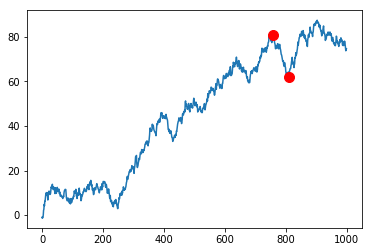

In [19]:
n = 1000
xs = np.random.randn(n).cumsum()
i = np.argmax(np.maximum.accumulate(xs) - xs) # end of the period
j = np.argmax(xs[:i]) # start of period


mdd = 0
peak = X[0]
for x in X:
    if x > peak: 
        peak = x
        dd = (peak - x) / peak
        if dd > mdd:
            mdd = dd


max_drawdown = j-i

print("Max drawdown:", max_drawdown,
     "I =", i,
     "J =", j)

plt.plot(xs)
plt.plot([i, j], [xs[i], xs[j]], 'o', color='Red', markersize=10)

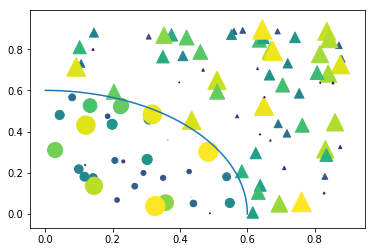

In [18]:
np.random.seed(19680801)


N = 100
r0 = 0.6
x = 0.9 * np.random.rand(N)
y = 0.9 * np.random.rand(N)
area = (20 * np.random.rand(N))**2  # 0 to 10 point radii
c = np.sqrt(area)
r = np.sqrt(x * x + y * y)
area1 = np.ma.masked_where(r < r0, area)
area2 = np.ma.masked_where(r >= r0, area)
plt.scatter(x, y, s=area1, marker='^', c=c)
plt.scatter(x, y, s=area2, marker='o', c=c)
# Show the boundary between the regions:
theta = np.arange(0, np.pi / 2, 0.01)
plt.plot(r0 * np.cos(theta), r0 * np.sin(theta))

plt.show()

In [28]:
print(x)
print(y)
print(area)

[0.630 0.668 0.638 0.510 0.880 0.636 0.223 0.142 0.628 0.648 0.232 0.307
 0.872 0.625 0.420 0.633 0.461 0.836 0.666 0.560 0.586 0.357 0.489 0.720
 0.649 0.266 0.145 0.186 0.121 0.433 0.308 0.327 0.876 0.100 0.349 0.705
 0.876 0.435 0.303 0.511 0.043 0.350 0.816 0.145 0.669 0.570 0.292 0.830
 0.214 0.742 0.676 0.102 0.761 0.832 0.199 0.840 0.440 0.427 0.080 0.207
 0.644 0.447 0.690 0.807 0.695 0.834 0.553 0.548 0.616 0.226 0.754 0.107
 0.718 0.854 0.133 0.816 0.710 0.692 0.539 0.398 0.651 0.375 0.204 0.409
 0.763 0.843 0.860 0.353 0.637 0.117 0.318 0.364 0.584 0.030 0.484 0.119
 0.469 0.092 0.142 0.828]
[0.706 0.357 0.139 0.649 0.753 0.844 0.519 0.176 0.106 0.856 0.255 0.861
 0.818 0.296 0.857 0.105 0.787 0.887 0.675 0.887 0.891 0.055 0.003 0.731
 0.524 0.135 0.137 0.474 0.431 0.083 0.461 0.039 0.726 0.218 0.763 0.626
 0.325 0.455 0.265 0.594 0.481 0.175 0.776 0.880 0.794 0.475 0.199 0.182
 0.068 0.857 0.791 0.809 0.059 0.314 0.435 0.681 0.051 0.206 0.566 0.260
 0.896 0.376 0.887 0.686 

In [22]:
print(test2.activity)
print(test2.activity[1:,])
print(test2.activity.dtype.names)

[(    0, 0.000,       0, 0, 0.000,       0, 0.000)
 (    1, 112.603,     200, 8, 112.609,    5325, 0.048)
 (    2, 112.606,    5344, 8, 112.660,    8022, 0.432) ...
 (12172, 109.149, 3184423, 9, 109.205, 3184755, 0.504)
 (12173, 109.181, 3185005, 9, 109.175, 3185053, -0.054)
 (12174, 109.179, 3185065, 9, 109.201, 3185468, 0.198)]
[(    1, 112.603,     200, 8, 112.609,    5325, 0.048)
 (    2, 112.606,    5344, 8, 112.660,    8022, 0.432)
 (    3, 112.663,    8042, 8, 112.655,    8136, -0.064) ...
 (12172, 109.149, 3184423, 9, 109.205, 3184755, 0.504)
 (12173, 109.181, 3185005, 9, 109.175, 3185053, -0.054)
 (12174, 109.179, 3185065, 9, 109.201, 3185468, 0.198)]
('Trade', 'Bid', 'Bid_TID', 'Units', 'Ask', 'Ask_TID', 'Profit')


In [ ]:
%%time

#Graphing
plt.figure(figsize=(15,10))
plt.grid(True)
plt.plot(df_analysis_final['Bid'], label='Bid')
plt.plot(df_analysis_final['Ask'], label='Ask')
plt.plot(df_analysis_final['Bid_Fast_Avg'], label='Bid_Fast_Avg')
plt.plot(df_analysis_final['Bid_Slow_Avg'], label='Bid_Slow_Avg')
plt.plot(df_analysis_final['Ask_Fast_Avg'], label='Ask_Fast_Avg')
plt.plot(df_analysis_final['Ask_Slow_Avg'], label='Ask_Slow_Avg')
#plt.plot(df_analysis_final['Spread_Fast_Avg'], label='Spread_Fast_Avg')
#plt.plot(df_analysis_final['Spread_Slow_Avg'], label='Spread_Slow_Avg')
plt.legend(loc=2)

plt.show()



In [ ]:
#testing empty array creation and appending

activity = np.empty((1,), dtype=[('Trade', 'int32'), ('Bid', 'float64'),('Ask', 'float64'), ('Profit', 'float64')])

new_row = np.empty_like(activity)

new_row[0]['Trade']=1
new_row[0]['Bid']=1.234
new_row[0]['Ask']=1.567
new_row[0]['Profit']=27.34

print("new row is:",new_row)
print("activity is:",activity)

activity = np.append(activity, new_row)
print("activity is:",activity)

new_row[0]['Trade']=2
new_row[0]['Bid']=2.234
new_row[0]['Ask']=2.567
new_row[0]['Profit']=1.34

print("new row is:",new_row)
print("activity is:",activity)

activity = np.append(activity, new_row)
print("activity is:",activity)


'''
new_row[0]['Trade']=1

activity = np.append(activity, new_row)

print(new_row)

#activity = np.vstack((activity, new_row))

activity[0,1]=1

print(activity)
print(activity.dtype)

'''

In [29]:
print(arr_analysis[1:3])

[('USD/JPY', '2018-01-01T22:12:13.601000000', 112.604, 112.661, 201, -0.057, 112.605, 112.605, 112.604, 112.604, 112.678, 112.679, 112.664, 112.665, -0.074, -0.074, -0.061, -0.061)
 ('USD/JPY', '2018-01-01T22:12:13.823000000', 112.603, 112.661, 202, -0.058, 112.605, 112.605, 112.604, 112.604, 112.678, 112.678, 112.664, 112.664, -0.073, -0.074, -0.060, -0.061)]


In [ ]:
#array index testing
#print(arr_analysis)

i=0
for x in np.ndenumerate(arr_analysis[0:10]):    
    print(arr_analysis[i]['TID'], i)
    #print(index, x)
    #print(arr_analysis[index])
    i += 1


In [ ]:
%%time
#Export sample data

# Create a Pandas Excel writer using XlsxWriter as the engine.
writer = pd.ExcelWriter('df_analysis_final.xlsx', engine='xlsxwriter')

# Convert the dataframe to an XlsxWriter Excel object.
df_analysis_final.head(100000).to_excel(writer, sheet_name='Sheet1')

# Close the Pandas Excel writer and output the Excel file.
writer.save()

#592 total transactions 295 buy and 297 sell


In [ ]:
%%time

#Test on actual data using dataframe. Slow - takes 5-7 minutes
#TTime isn't unique! 2018-01-01 22:13:03.523000 USDJPY

test2 = Test(50000,0)
test2.acct_status()


for index, row in df_analysis_final.iterrows():
    
    #display("the row is:", row['Bid_Fast_Avg'])
    
    if (row['Bid_Fast_Avg'] < row['Ask_Slow_Avg'] and test2.buy_status == 1):
        test2.buy(1000, row['Bid'], row['TID'])

    elif (row['Bid_Fast_Avg'] > row['Ask_Slow_Avg'] and test2.sell_status == 1):    
        test2.sell(row['Ask'],row['TID'])
    
test2.acct_status()

#print ("account balance is:", account_bal, "equity is:", equity)
    


In [ ]:
#Test iterating through arrays and calling class methods
bid = [1.24, 1.26, 1.20, 1.38, 1.32]
ask = [1.19, 1.27, 1.24, 1.40, 1.32]
indicator = [1,2,0,1,1]

for i in range(len(indicator)):
    #print(i, bid[i], ask[i])
    if indicator[i] == 1:
        test1.buy(100, bid[i])
    elif indicator[i] == 2:
        test1.sell(ask[i])
    test1.acct_status()


In [ ]:
pd.options.display.max_rows = 100
display(df_analysis_final)

In [ ]:
%%time

#df_analysis_buy = pd.DataFrame(df_analysis_final[df_analysis_final.Bid_Fast_Avg > df_analysis_final.Ask_Slow_Avg])

df_analysis_buy = df_analysis_final.query('Bid_Fast_Avg > Ask_Slow_Avg')

display(df_analysis_buy)
#df_analysis_sell[df_analysis_final.Bid_Fast_Avg > df_analysis_final.Ask_Slow_Avg]

In [ ]:
>>> from numpy.random import randn
>>> from pandas import DataFrame
>>> df = pd.DataFrame(randn(10, 2), columns=list('ab'))
print(df)
>>> print(df.query('a > b'))
>>> print(df[df.a > df.b])

In [ ]:
%%time
from IPython.display import display
pd.options.display.max_columns = None

#Sort dataframe on date
df_tick_data_sorted=df_tick_data.sort_values(by=['TTime'])
df_tick_data_sorted.set_index('TTime')
df_tick_data_sorted['TID'] = range(0, len(df_tick_data_sorted))
df_tick_data_sorted['Bid_Ask_Spread']=df_tick_data_sorted['Bid'] - df_tick_data_sorted['Ask']
#display(df_tick_data_sorted.rolling(20, on=['Bid_Ask_Spread']))
display(df_tick_data_sorted)
print("Process time:",time.process_time())
#display(df_tick_data_sorted.index)
#Add date key

In [ ]:
print("df_analysis_final is", type(df_analysis_final))

#display(df_analysis_final)

In [ ]:
%%time
'''Creating empty base and final arrays'''

arr_data=df_tick_data_sorted[:300000] #need to 1)find right datatype (smallest) 2)optimize structure, and 3)determine memory usage
#print(test_data)

arr_base_len=len(arr_data.index)
arr_final_len= len(arr_data.index)-1
#arr_final_len= (len(arr_data.index)*(len(arr_data.index)-1))//2


arr_base=np.zeros(arr_base_len, dtype={'names':('TID','Bid','Ask'),
                          'formats':('int','f8','f8')})

arr_final=np.zeros(arr_final_len, dtype={'names':('PTimeID','STimeID', 'PTBid','PTAsk', 'STBid', 'STAsk', 'Profit', 'SBid_Ask_Spread','PBid_Ask_Spread','Tick_Delta'),
                          'formats':('int','int', 'f8','f8','f8','f8','f8','f8','f8','int')})

print(arr_final.dtype.itemsize)
print(arr_final.nbytes)
print(arr_final)

In [ ]:
%%time

'''This writes the dataframe to an array'''
for index, row in arr_data.iterrows():
    #print(index, test_data.loc[index,'TTime'])
    arr_base[index]=(arr_data.loc[index,'TID'], arr_data.loc[index,'Bid'],arr_data.loc[index,'Ask'])

print(arr_base.shape)
print(arr_base)
'''
print(arr_base[0])
print(arr_base[0][0])

curr_row=0
for x in range(1, 10):
    print("base row", arr_base[curr_row])
    curr_row+=1
    print("subsequent rows", arr_base[curr_row:])
'''

In [ ]:
%%time
'''This is the final array (concat + PTime, STime, PPrice, SPrice, Profit). 
This is using the index logic and not go through each row.
Need to use multiprocessor.'''

y=0
curr_row=0
total_concat_rows=0
for x in np.nditer(arr_base):
    
    #set up array chunks. max tick_delta is 20343
    arr_base_subset_beg=curr_row+1
    if arr_final_len - arr_base_subset_beg >30000:
        arr_base_subset_end=arr_base_subset_beg+30000
    else:
        arr_base_subset_end = arr_final_len + 1
    
    #define arr_analysis
    arr_analysis_len = arr_base_subset_end - arr_base_subset_beg  
    arr_analysis=np.zeros(arr_analysis_len, dtype={'names':('PTimeID','STimeID', 'PTBid','PTAsk', 'STBid', 'STAsk', 'Profit', 'SBid_Ask_Spread','PBid_Ask_Spread','Tick_Delta'),
                          'formats':('int','int', 'f8','f8','f8','f8','f8','f8','f8','int')})

    if arr_analysis.shape != (0,):
        
        #populate static purchase values
        arr_analysis[['PTimeID','PTBid','PTAsk']]=arr_base[curr_row][['TID','Bid','Ask']]
        #populate subsequent transaction values
        arr_analysis[['STimeID','STBid','STAsk']] = arr_base[arr_base_subset_beg:arr_base_subset_end][['TID','Bid','Ask']]
        #arr_analysis[['Profit']]= arr_analysis['STBid'] 
        #calculate transaction metrics
        arr_analysis['Profit']=arr_analysis['STBid'] - arr_analysis['PTBid']
        arr_analysis['SBid_Ask_Spread']=arr_analysis['STBid'] - arr_analysis['STAsk']
        arr_analysis['PBid_Ask_Spread']= arr_analysis['PTBid'] - arr_analysis['PTAsk']
        arr_analysis['Tick_Delta']= arr_analysis['STimeID'] - arr_analysis['PTimeID']

        #print("this is arr_analysis", arr_analysis)

        #arr_analysis_max = arr_analysis[np.argmax(arr_analysis['Profit'])]
        #print("max profit:", arr_analysis_max)

        arr_final[curr_row] =  arr_analysis[np.argmax(arr_analysis['Profit'])]
        #print("final array:", arr_final)

        curr_row+=1

print(arr_final)

In [ ]:
print(np.max(arr_final['Tick_Delta']))

In [ ]:
plt.scatter(arr_final['Tick_Delta'],arr_final['Profit'])
plt.show()

In [ ]:
arr_his=np.where(arr_final['Profit']>0)
print(arr_his)
plt.hist(arr_final['Tick_Delta'])
plt.show()
plt.hist(arr_final['Profit'])
plt.show()

In [ ]:
df_final = pd.DataFrame(arr_final)
df_final_profit=df_final[df_final['Profit']>.1]
#display(df_final[df_final['Profit']>.1])
plt.hist(df_final_profit['Tick_Delta'])
plt.show()
plt.hist(df_final_profit['Profit'])
plt.show()

In [ ]:
plt.scatter(df_final_profit['Tick_Delta'],df_final_profit['Profit'])
plt.show()

In [ ]:
from scipy.stats.stats import pearsonr

print("only profit:", pearsonr(df_final_profit['Tick_Delta'],df_final_profit['Profit']))
print("entire dataset:", pearsonr(arr_final['Tick_Delta'],arr_final['Profit']))

In [ ]:
df_final_loses=df_final[df_final['Profit']<0]
display(df_final_loses)
print(sum(df_final['Profit']))